In [2]:
import json
from stop_words import get_stop_words
from gensim.models.doc2vec import TaggedDocument,Doc2Vec
import pandas as pd
import numpy as np
from scipy import spatial,stats
import matplotlib.pyplot as plt
import csv

<h2>Text Data</h2>

Reads in the ISEAR emotion dataset into Pandas dataframe. http://emotion-research.net/toolbox/toolboxdatabase.2006-10-13.2581092615

In [181]:
df_isear = pd.read_csv('ISEAR1.csv',index_col=False)

In [182]:
df_isear.head()

,emotion,text
0,joy,On days when I feel close to my partner and ot...
1,fear,Every time I imagine that someone I love or I ...
2,anger,When I had been obviously unjustly treated and...
3,sadness,When I think about the short time that we live...
4,disgust,At a gathering I found myself involuntarily si...


<h2>Data Preparation and Doc2Vec Model Creation</h2>

Define functions to process text and create a doc2vec model.

First function takes a collection of articles or strings items and creates a doc2vec model

In [183]:
def create_doc2vec_model(articles,name,vector_size=100,epochs=10,lang='en'):
    # import stopwords for specific language of model
    stop_words = get_stop_words(lang)
    ## list of just articles (str)
    #strip stopwords article docs
    nostop = [[i for i in doc.lower().split() if i not in stop_words] for doc in articles]
    #tokenize article docs and convert to doc2vec tagged docs - each article has an index number and list of tokens - taggedoc(['token1','token2',[1]])
    tagged = [TaggedDocument(doc,[i]) for i,doc in enumerate(nostop)]
    # instantiate doc2vec model with parameters - size = # of nums representing each doc (100), min_count - occurences of words in vocab (filter out rare words), iter - passes to create vectors
    model = Doc2Vec(vector_size=vector_size, min_count=2, epochs=epochs)
    ## build vocab from all tagged docs
    model.build_vocab(tagged)
    ## train model on tagged docs - total examples - total # of docs
    model.train(tagged,total_examples=model.corpus_count,epochs=epochs)
    # save model with language - eg esmodel.model for spanish docs
    model_name = name + 'model.model'
    model.save(model_name)
    model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    print('saved as: ' + model_name)

Converts a list of articles (strings) and infers the vector from the doc2vec model previously created. 
Input ['string1','string2','string3']

In [184]:
def text2vec(textlist,lang,d2v_model):
    stop_words = get_stop_words(lang)
    histnostop = [[i for i in doc.lower().split() if i not in stop_words] for doc in textlist]
    dlhist_tagged = [TaggedDocument(doc,[i]) for i,doc in enumerate(histnostop)]
    ## infer vectors from current doc2model
    vecs = [d2v_model.infer_vector(doc.words) for doc in dlhist_tagged]
    return vecs

<h2>Creates and Loads Doc2Vec Model</h2>

Creates a doc2vec model from just the text of the dataframe. 

In [185]:
emot_text = df_isear['text']

In [186]:
create_doc2vec_model(emot_text,'emotions1',vector_size=100,epochs=10,lang='en')

saved as: emotions1model.model


In [187]:
d2v_model = Doc2Vec.load('emotions1model.model')

<h2>Text Item Vectors</h2>

Gets the vectors for each text item in the dataframe from the doc2vec just created and add them to dataframe.

In [188]:
emot_vecs = [d2v_model.docvecs[x] for x in range(len(emot_text))]
len(emot_vecs)

7516

In [189]:
df_isear['emot_vecs'] = emot_vecs

<h2>Group Vectors by Emotion</h2>

Group Dataframe by emotion(anger,joy,sadness etc.).

In [190]:
emotions_grp = list(df_isear.groupby(df_isear['emotion']))

<h2>Calculate Vector Mean for Each Emotion Group</h2>

Get vector means (centers) for each emotion group. This represents the central location in the vector space for each emotion. The closer a text vector representation is to a given emotion group mean, the more the given text is characterized by the emotion the mean represents. 

Example: the closer a given sentence is to the 'anger' vector center, the more that sentence is characterized by anger. I purposely use the word 'characterize' because the model can capture a wide variation of relations to the emotion - expressions, descriptions, evaluations, etc. 

A characterization of an emotion contains all 3 of the following cases:

An expression of anger - "I hate that no good bastard and I want to bash his head in.' 
A description of anger - "When she told him she cheated, he banged his fist against the wall and gritted his teeth'
A evaluation of someone else's anger - "I was so disappointed when cursed and stormed out of the room when given the news.' 

Another viewpoint sees the emotion 'score' as the amount of emotion 'content' in the sentence, without necessarily being an expression of that emotion. The third sentence, for instance, is an expression of disappointment, though it has high anger 'content.' A sentence with a high anger 'score,' therefore, doesn't mean the sentence itself is particularly angry. 

We can then evaluate a sentence for it's emotional 'content' by calculating the distance of the sentence vector from each of the emotion vector means. 

In [191]:
emot_vec_mean = [{'emotion':emotions_grp[x][0],'vec':emotions_grp[x][1]['emot_vecs'].mean()} for x in range(len(emotions_grp))]

In [192]:
emot_vec_mean1 = [emot_vec_mean[x]['vec'] for x in range(len(emot_vec_mean))]

In [193]:
emot_vecs_ctr = [x['vec'] for x in emot_vec_mean]
emot_label_ctr = [x['emotion'] for x in emot_vec_mean]

<h2>Create .tsv files</h2>

Functions for creating tsv files for use in a Tensorflow Embedding Projector

In [194]:
## outputs and saves a tsv file for a list of vectors
def output_tab_vecs(vecs,filename):
    csv.register_dialect('tabDialect', delimiter='\t', quoting=csv.QUOTE_NONE)
    myFile = open(filename, 'w')  
    with myFile:  
        writer = csv.writer(myFile, dialect='tabDialect')
        writer.writerows(vecs)
    print('saved tab file as',filename)

In [1]:
## outputs and saves a tsv file for a list of meta tags (2 columns or more)
def output_tab_meta(meta,filename):
    meta1 = [('emotion','text')] + meta 
    csv.register_dialect('tabDialect', delimiter='\t', quoting=csv.QUOTE_NONE,escapechar='\\')
    myFile = open(filename, 'w')  
    with myFile:  
        writer = csv.writer(myFile, dialect='tabDialect')
        writer.writerows(meta1)
    print('saved tab file as',filename)

In [196]:
## outputs and saves a tsv file for a list of single column meta tags
def output_single_meta(metalist,filename):
    with open (filename, 'w') as fo:
        for d in metalist:
            fo.write(str(d) + '\n')
    print('saved tab file as',filename)

Output tsv files for the vector means for each emotion and theirs labels as well as the vectors for each sentence and their labels (emotion,sentence text). 

In [197]:
output_tab_vecs(emot_vecs_ctr,'emot_vecs_means.tsv')

saved tab file as emot_vecs_means.tsv


In [198]:
output_single_meta(emot_label_ctr,'emot_labels_means.tsv')

saved tab file as emot_labels_means.tsv


In [199]:
output_tab_vecs(emot_vecs,'emot_vecs_sent.tsv')

saved tab file as emot_vecs_sent.tsv


In [200]:
meta_list = list(zip(df_isear['emotion'],df_isear['text']))
output_tab_meta(meta_list,'emot_labels_sent.tsv')

saved tab file as emot_labels_sent.tsv


<h2>Tensorflow Embedding Projector </h2>

Links use data previously generated in this notebook that is hosted on github. To use yoru own data, one can generate the required tsv files with the functions above and then upload the vec and meta .tsv files to the embedding projector with the 'Load Data' button and choose the appropriate file (vectors or metadata). 

<h3>All Sentences</h3>

Select 'emotion' for 'color by' so points will be colored by the emotion label.

https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/escottgoodwin/f3728570bf3c7e13a750dd93117053ac/raw/4b07e02ca7aa91b57214d18be8aed255f3346937/emot_vec_sent_projector_config.json

<h3>Emotion Vector Means</h3>

Select 'emotion' for 'color by' so points will be colored by the emotion label.

https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/escottgoodwin/1a8e0715f2c6029e835f4a6e315bdd92/raw/e6e3f74a0f32aa66aeadb3b3e65e403cc1cd6992/emotion_centers_projector_config.json

<h2>Emotional Content Predictions</h2>

Predicts the emotional content of a list of text articles (strings) 

<b>Outputs:</b>

1 - score for each of the 7 emotions based on cosine distance from emotion vector means - anger:84,joy:21,sadness: .65

2 - dominant emotion (to compare to original ISEAR dataset that had 1 emotion per sentence) - anger

3 - ranks of the each of the 7 emotions - in reverse order by distance - most dominant emotion would be 7 - joy:1,sadness:5, anger:7 

4 - inferred vectors each item in the list of text articles

In [168]:
def predict_emotions(text_list,lang,emot_vec_mean,model_name):
    d2v_model = Doc2Vec.load(model_name)
    text_vecs = text2vec(text_list,lang,d2v_model)
    emot_scan = [{x['emotion']:1 - spatial.distance.cosine(sample_vec,x['vec']) for x in emot_vec_mean} for sample_vec in text_vecs]
    emot_scan1 = [[1 - spatial.distance.cosine(sample_vec,x['vec']) for x in emot_vec_mean] for sample_vec in text_vecs]
    emot_pred = [np.argmax(x) for x in emot_scan1]
    ranks = [stats.rankdata(x) for x in emot_scan1]
    emotions = [x['emotion'] for x in  emot_vec_mean]
    emot_ranks = []
    for x in range(len(ranks)):
        emot_rank = list(zip(emotions,ranks[x]))
        emot_ranks.append(emot_rank)
    return emot_scan,emot_scan1,emot_pred,emot_ranks,text_vecs

In [172]:
sample_sent = ['You mean so much to me and I love you.','How could you do that you bastard. I cannot stand you!'] #sentences must be in a list
emot_scan,emot_scan1,emot_pred,ranks,text_vecs = predict_emotions(sample_sent,'en',emot_vec_mean,'emotions1model.model')

In [174]:
emot_scan

[{'anger': 0.9852735996246338,
  'disgust': 0.985318660736084,
  'fear': 0.9851565361022949,
  'guilt': 0.9853554964065552,
  'joy': 0.9850506782531738,
  'sadness': 0.9850685000419617,
  'shame': 0.9853231906890869},
 {'anger': 0.9795728921890259,
  'disgust': 0.9795154929161072,
  'fear': 0.9794973134994507,
  'guilt': 0.9795477986335754,
  'joy': 0.9796198010444641,
  'sadness': 0.9794784188270569,
  'shame': 0.9796500205993652}]

In [175]:
ranks


[[('anger', 4.0),
  ('disgust', 5.0),
  ('fear', 3.0),
  ('guilt', 7.0),
  ('joy', 1.0),
  ('sadness', 2.0),
  ('shame', 6.0)],
 [('anger', 5.0),
  ('disgust', 3.0),
  ('fear', 2.0),
  ('guilt', 4.0),
  ('joy', 6.0),
  ('sadness', 1.0),
  ('shame', 7.0)]]

<h2>Emotions Related By Distance</h2>

One nice feature of modeling the emotional content of the text in the vector space this way is that it takes into account that certain emotions are related (or near in vector space) to one another. This is an improvement upon an LDA style model that would simply give proportions percentages of emotional content that add to %100 - anger:25%, joy: 5%. 

Of course, one could transform the scores into percentages, but the accuracy of the characterization might be lost. 

In this model, the vector means for disgust and anger are near one another, so one would expect that a text that 'scored' high for anger, would also 'score' high for disgust. 

How accurate the relations (or distances) depicted by the model are another matter. Anger and disgust being so close makes a cetain amount of sense. However, joy and sadness between so close together and shame and guilt being so far apart make less sense. Now is this fault of the modeling method or a peculiarity of the dataset?  

<center><h4>Emotion Vector Centers</h4></center>

<img src="screenshotemotvec.png">

<h2>Emotion Cluster Separation</h2>

The following functions explores how well the various emotion vector means are seperated by looking at the cosine distances between the vector means and the text vectors in each of the emotion groups. 

We calculate the distances between the vector mean for anger and all the text vectors in the anger group. We do the same for the anger vector mean and the all the articles in the six other groups (anger mean and disgust text vectors, anger mean and sadness text vectors etc). 

In [118]:
def emotion_ctr_dist(emot,ctr):
    emot_ser = df_isear[df_isear['emotion']==emot]['emot_vecs']
    emot_dist = np.array([spatial.distance.cosine(ctr,x) for x in emot_ser])
    print(emot)
    print(stats.describe(emot_dist))
    plt.hist(emot_dist)
    plt.show()

In [119]:
def ctr_dist_compare(emot_list,ctr_list):
    for emotion in emot_list:
        print('main emotion',emotion)
        for ctr in emot_vec_mean:
            print(ctr['emotion'])
            emotion_ctr_dist(emotion,ctr['vec'])

main emotion anger
anger
anger
DescribeResult(nobs=1079, minmax=(0.00035458803176879883, 1.9682884812355042), mean=0.09095204708325454, variance=0.08293239413762803, skewness=4.850336303302447, kurtosis=24.09622659826712)


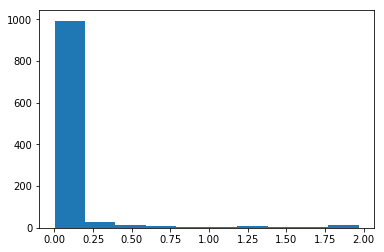

disgust
anger
DescribeResult(nobs=1079, minmax=(0.0003922581672668457, 1.9684520363807678), mean=0.09098546307208308, variance=0.08294473737468186, skewness=4.8499342399904934, kurtosis=24.092036059545272)


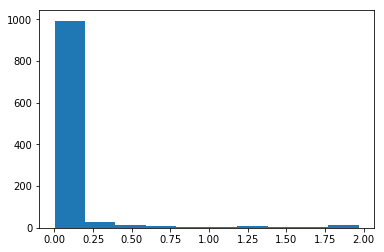

fear
anger
DescribeResult(nobs=1079, minmax=(0.00035685300827026367, 1.9683982729911804), mean=0.09099505993885179, variance=0.08294744458746893, skewness=4.849541105344978, kurtosis=24.088044582996986)


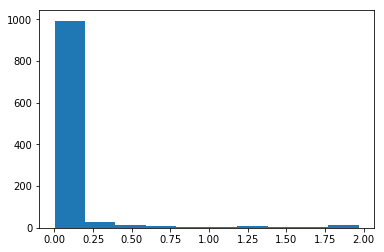

guilt
anger
DescribeResult(nobs=1079, minmax=(0.0003884434700012207, 1.968123733997345), mean=0.09098690082856382, variance=0.08293510375694006, skewness=4.849525431340841, kurtosis=24.088481716130214)


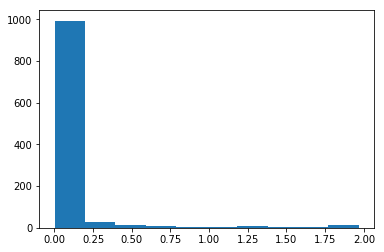

joy
anger
DescribeResult(nobs=1079, minmax=(0.00038421154022216797, 1.9685894846916199), mean=0.0909991765614124, variance=0.08295749857241674, skewness=4.849985609336084, kurtosis=24.092683880824108)


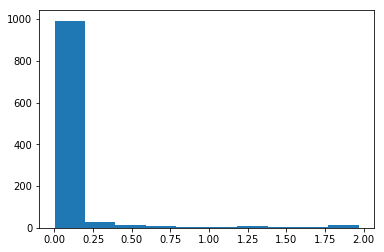

sadness
anger
DescribeResult(nobs=1079, minmax=(0.00040203332901000977, 1.9684239029884338), mean=0.09100216049222475, variance=0.08294943473221764, skewness=4.85016342052226, kurtosis=24.094714849531236)


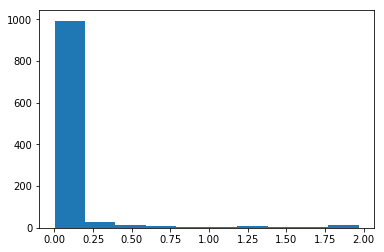

shame
anger
DescribeResult(nobs=1079, minmax=(0.00038880109786987305, 1.9682785868644714), mean=0.09098093375349864, variance=0.08294347260198694, skewness=4.849963313341401, kurtosis=24.092728893962086)


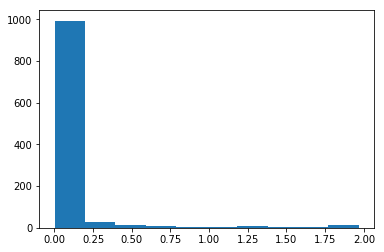

main emotion disgust
anger
disgust
DescribeResult(nobs=1066, minmax=(0.00034308433532714844, 1.9673448204994202), mean=0.09213308460126311, variance=0.07848256344627201, skewness=4.820195522454837, kurtosis=24.069286774633877)


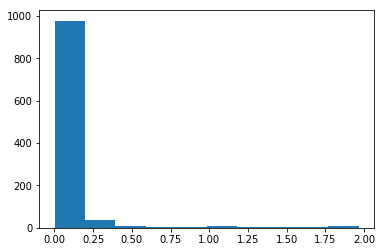

disgust
disgust
DescribeResult(nobs=1066, minmax=(0.00032263994216918945, 1.9672598838806152), mean=0.09209919232511665, variance=0.07847206664539266, skewness=4.820262992284738, kurtosis=24.06979239610278)


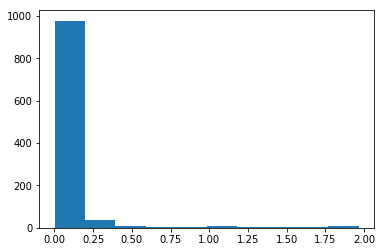

fear
disgust
DescribeResult(nobs=1066, minmax=(0.0003268718719482422, 1.9673609733581543), mean=0.09214494810710482, variance=0.07849626194471479, skewness=4.81940338031637, kurtosis=24.060886436288357)


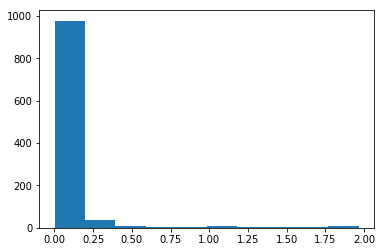

guilt
disgust
DescribeResult(nobs=1066, minmax=(0.00034332275390625, 1.967365801334381), mean=0.09212875616776899, variance=0.07847342040524516, skewness=4.820540535973054, kurtosis=24.072872767238)


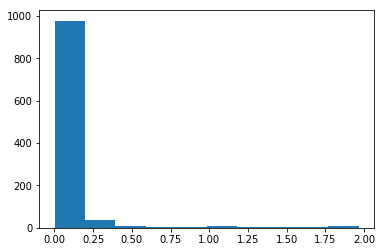

joy
disgust
DescribeResult(nobs=1066, minmax=(0.00035059452056884766, 1.9673992991447449), mean=0.09214836586175895, variance=0.07847984514027366, skewness=4.820072883749195, kurtosis=24.069020545727177)


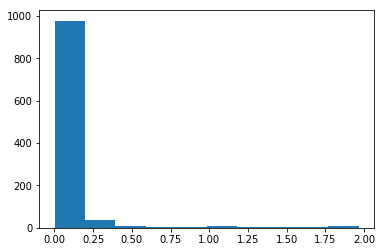

sadness
disgust
DescribeResult(nobs=1066, minmax=(0.00036525726318359375, 1.9675929546356201), mean=0.09214780166287387, variance=0.07848231866882655, skewness=4.819930977554111, kurtosis=24.067639134087898)


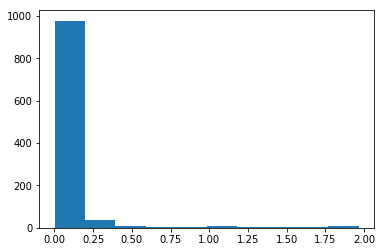

shame
disgust
DescribeResult(nobs=1066, minmax=(0.00037604570388793945, 1.9672937393188477), mean=0.09213192417508247, variance=0.07849012447486294, skewness=4.820352513499394, kurtosis=24.071077121713827)


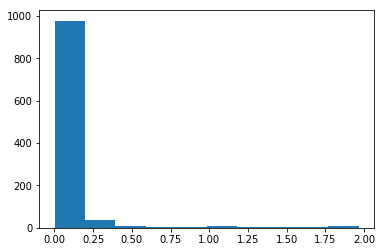

main emotion fear
anger
fear
DescribeResult(nobs=1076, minmax=(0.00032198429107666016, 1.9311689734458923), mean=0.10682303428255648, variance=0.09568215142092311, skewness=4.321079855620955, kurtosis=18.967622590069332)


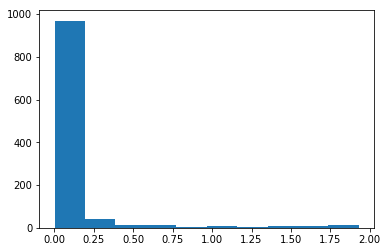

disgust
fear
DescribeResult(nobs=1076, minmax=(0.0003333091735839844, 1.9309576153755188), mean=0.1068231235217168, variance=0.09568753237665004, skewness=4.3210929602833765, kurtosis=18.967671999805063)


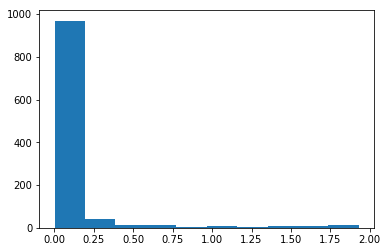

fear
fear
DescribeResult(nobs=1076, minmax=(0.00034493207931518555, 1.9310019612312317), mean=0.10677465763255489, variance=0.09565083356796673, skewness=4.321327226132418, kurtosis=18.969808104587894)


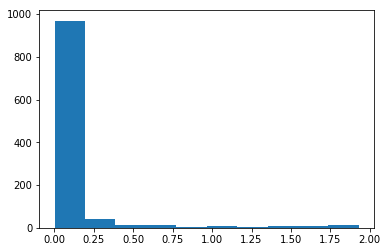

guilt
fear
DescribeResult(nobs=1076, minmax=(0.00033795833587646484, 1.9307908415794373), mean=0.10684042777483123, variance=0.09568386848806408, skewness=4.321197383006347, kurtosis=18.969288041580885)


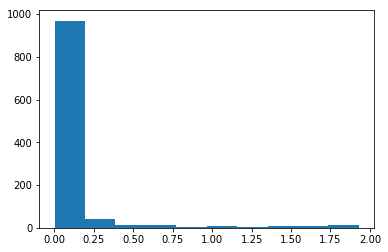

joy
fear
DescribeResult(nobs=1076, minmax=(0.00034672021865844727, 1.9313061237335205), mean=0.10685112776380157, variance=0.09570186111838608, skewness=4.3207136691377634, kurtosis=18.964639404547352)


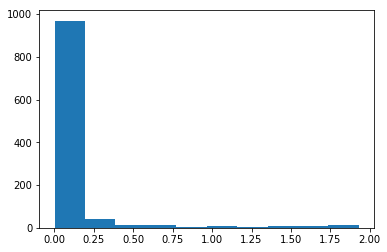

sadness
fear
DescribeResult(nobs=1076, minmax=(0.00034999847412109375, 1.9309155344963074), mean=0.10684930885089025, variance=0.09568841438777789, skewness=4.320934715181849, kurtosis=18.966915849385373)


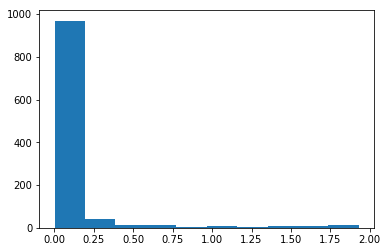

shame
fear
DescribeResult(nobs=1076, minmax=(0.00032138824462890625, 1.9313427805900574), mean=0.10683307046151623, variance=0.09569337612578804, skewness=4.321205043028436, kurtosis=18.96895785133694)


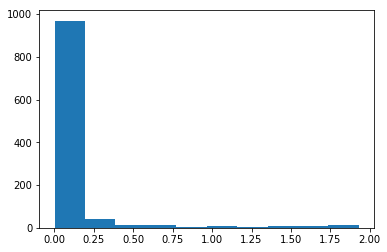

main emotion guilt
anger
guilt
DescribeResult(nobs=1050, minmax=(0.0004547238349914551, 1.9724078178405762), mean=0.12869275099464825, variance=0.12533858287452054, skewness=3.764022304675827, kurtosis=13.701879050973474)


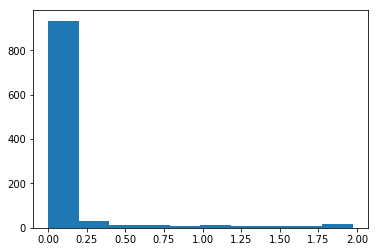

disgust
guilt
DescribeResult(nobs=1050, minmax=(0.0004954934120178223, 1.9723188281059265), mean=0.12869130268072088, variance=0.12533161957216268, skewness=3.7640577035119795, kurtosis=13.702059915046629)


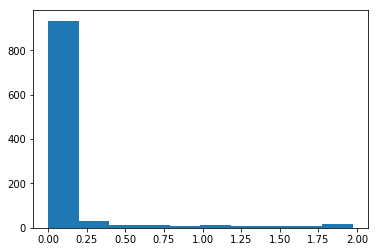

fear
guilt
DescribeResult(nobs=1050, minmax=(0.0005054473876953125, 1.9724253416061401), mean=0.12871098398319666, variance=0.12534361852677461, skewness=3.7639637924808707, kurtosis=13.701597320359717)


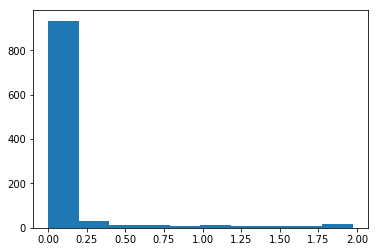

guilt
guilt
DescribeResult(nobs=1050, minmax=(0.00048273801803588867, 1.9721447229385376), mean=0.12864251890574538, variance=0.12529506890910674, skewness=3.7644816141847115, kurtosis=13.705768473067877)


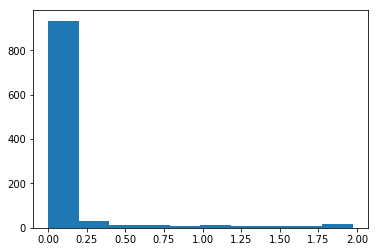

joy
guilt
DescribeResult(nobs=1050, minmax=(0.00046259164810180664, 1.9723413586616516), mean=0.128735765991289, variance=0.125356283776339, skewness=3.763682872655063, kurtosis=13.699411052579684)


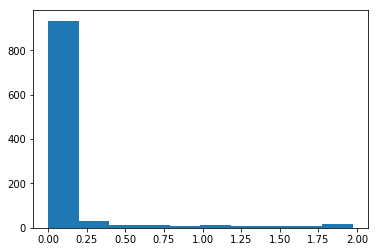

sadness
guilt
DescribeResult(nobs=1050, minmax=(0.0004735589027404785, 1.9724559783935547), mean=0.12870289105079358, variance=0.12532982127191872, skewness=3.7641618363021694, kurtosis=13.703296508332894)


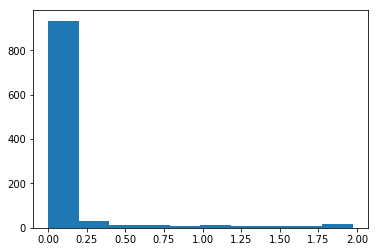

shame
guilt
DescribeResult(nobs=1050, minmax=(0.0004565715789794922, 1.972280740737915), mean=0.12870028401414554, variance=0.12533724571025087, skewness=3.763877550009814, kurtosis=13.700815436460466)


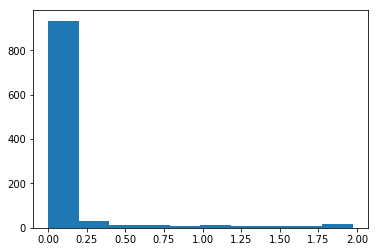

main emotion joy
anger
joy
DescribeResult(nobs=1092, minmax=(0.0002657771110534668, 1.981822907924652), mean=0.13894631604931826, variance=0.12180689093755072, skewness=3.64908191628294, kurtosis=13.230153997167573)


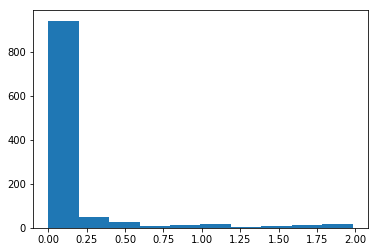

disgust
joy
DescribeResult(nobs=1092, minmax=(0.0002804398536682129, 1.9817818403244019), mean=0.13895790740830957, variance=0.12182283624624972, skewness=3.6489556696539993, kurtosis=13.229378439299381)


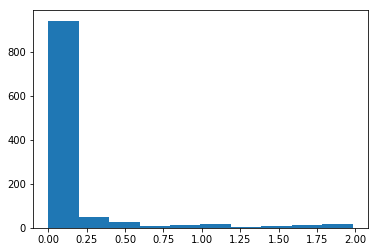

fear
joy
DescribeResult(nobs=1092, minmax=(0.0002766847610473633, 1.9818207621574402), mean=0.13895741695354372, variance=0.12180788717147271, skewness=3.6487120037176317, kurtosis=13.227367800434951)


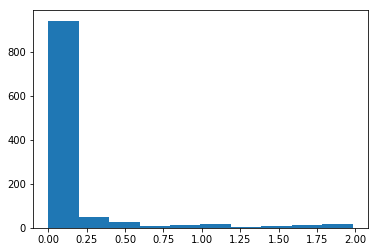

guilt
joy
DescribeResult(nobs=1092, minmax=(0.00030237436294555664, 1.981445848941803), mean=0.138960683051814, variance=0.12180803604853378, skewness=3.6491716032868893, kurtosis=13.230665079416994)


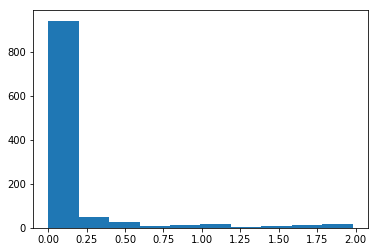

joy
joy
DescribeResult(nobs=1092, minmax=(0.0002682805061340332, 1.981914758682251), mean=0.13889862630079627, variance=0.12180204808881287, skewness=3.6491923162770585, kurtosis=13.230832163906921)


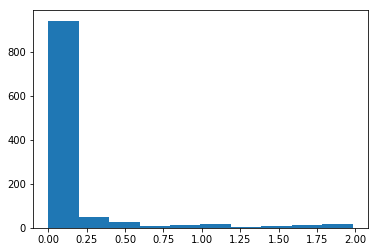

sadness
joy
DescribeResult(nobs=1092, minmax=(0.00029546022415161133, 1.9819726347923279), mean=0.13893674681178078, variance=0.12178595962548065, skewness=3.6492435816067963, kurtosis=13.231448696197216)


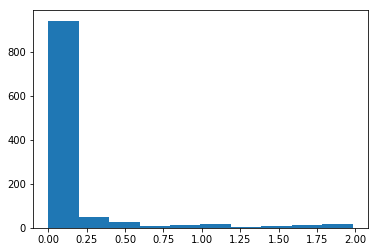

shame
joy
DescribeResult(nobs=1092, minmax=(0.00026673078536987305, 1.9817923307418823), mean=0.138955589135232, variance=0.12180153611780176, skewness=3.648875290545626, kurtosis=13.228787280611652)


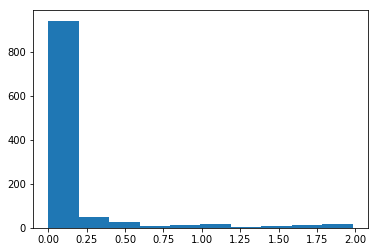

main emotion sadness
anger
sadness
DescribeResult(nobs=1082, minmax=(0.0003280043601989746, 1.9834248423576355), mean=0.16792420774281658, variance=0.15711393630701448, skewness=3.256399146372797, kurtosis=9.912609712610923)


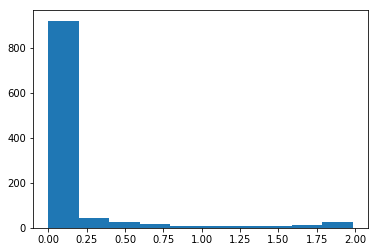

disgust
sadness
DescribeResult(nobs=1082, minmax=(0.0003439784049987793, 1.9834900498390198), mean=0.16791606971790907, variance=0.15711991379514967, skewness=3.256556045760202, kurtosis=9.913459637069888)


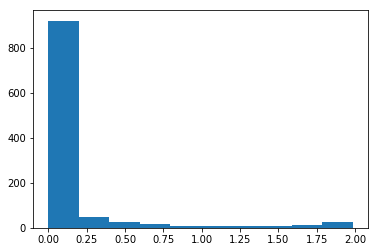

fear
sadness
DescribeResult(nobs=1082, minmax=(0.00035327672958374023, 1.9834486842155457), mean=0.1679270480898882, variance=0.15711628569065955, skewness=3.256548577234391, kurtosis=9.913625383188869)


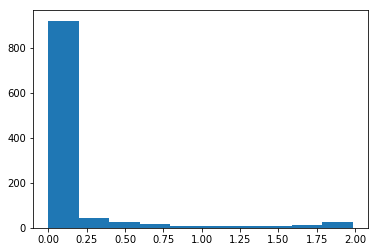

guilt
sadness
DescribeResult(nobs=1082, minmax=(0.0003185868263244629, 1.9833677411079407), mean=0.16792003614500908, variance=0.15711061201353724, skewness=3.2564646642277837, kurtosis=9.912902309070853)


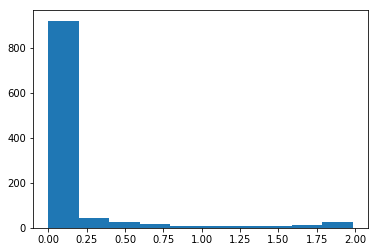

joy
sadness
DescribeResult(nobs=1082, minmax=(0.0003534555435180664, 1.9834986329078674), mean=0.1679108449328491, variance=0.15710584003227143, skewness=3.2566126854580535, kurtosis=9.913928839842358)


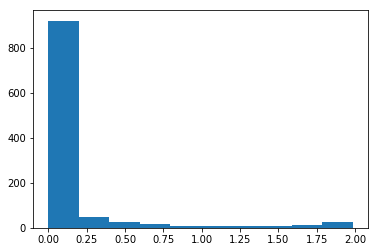

sadness
sadness
DescribeResult(nobs=1082, minmax=(0.000329434871673584, 1.9832709431648254), mean=0.1678390033988974, variance=0.15708429773480534, skewness=3.257109957992058, kurtosis=9.916837772964989)


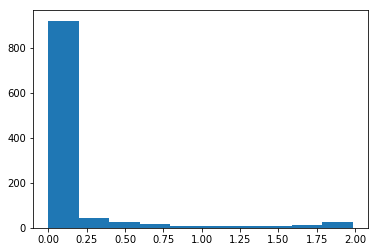

shame
sadness
DescribeResult(nobs=1082, minmax=(0.00035059452056884766, 1.9834662675857544), mean=0.1679165037727593, variance=0.15710932449249088, skewness=3.256567053038554, kurtosis=9.91369067561061)


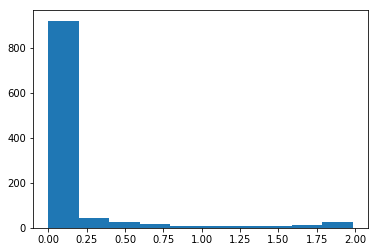

main emotion shame
anger
shame
DescribeResult(nobs=1071, minmax=(0.0006483197212219238, 1.9589728713035583), mean=0.12394739313870251, variance=0.12028812795168807, skewness=3.892346435993602, kurtosis=14.778788971121411)


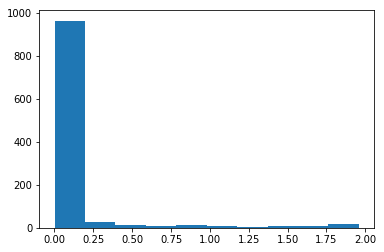

disgust
shame
DescribeResult(nobs=1071, minmax=(0.0006227493286132812, 1.9587107300758362), mean=0.12394884862544851, variance=0.12029336299464685, skewness=3.892599259255847, kurtosis=14.780899118475329)


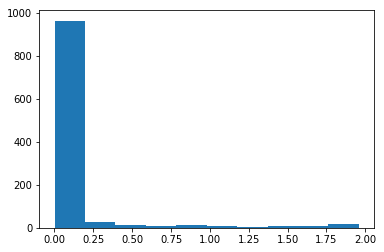

fear
shame
DescribeResult(nobs=1071, minmax=(0.000613868236541748, 1.9588101506233215), mean=0.12396738718478592, variance=0.12029606811644948, skewness=3.892184037785947, kurtosis=14.777599154557869)


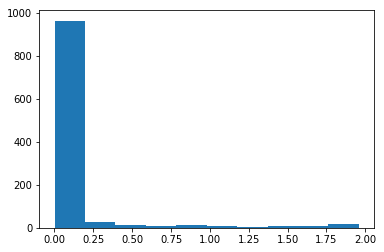

guilt
shame
DescribeResult(nobs=1071, minmax=(0.0006756186485290527, 1.95902681350708), mean=0.12394774078898459, variance=0.1202676299665236, skewness=3.892535481667746, kurtosis=14.780495157054602)


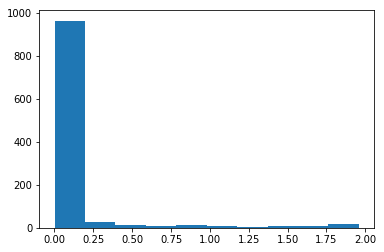

joy
shame
DescribeResult(nobs=1071, minmax=(0.0006580948829650879, 1.9588861465454102), mean=0.12396621021914299, variance=0.12027120375029887, skewness=3.8924678035854567, kurtosis=14.780654089127914)


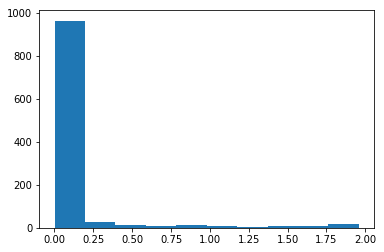

sadness
shame
DescribeResult(nobs=1071, minmax=(0.0006895065307617188, 1.9590566158294678), mean=0.12396878375907461, variance=0.12027488823483093, skewness=3.892400291879289, kurtosis=14.779915425224758)


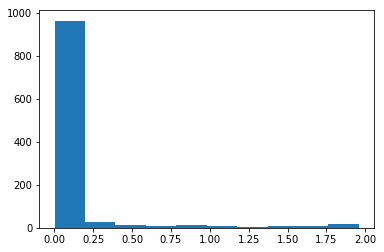

shame
shame
DescribeResult(nobs=1071, minmax=(0.0006204843521118164, 1.9588404893875122), mean=0.1239134790801924, variance=0.12026627603305962, skewness=3.8925484604354397, kurtosis=14.780470239189139)


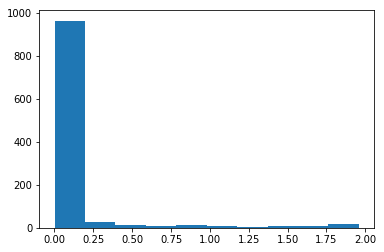

In [201]:
ctr_dist_compare(emot_lablel_ctr,emot_vecs_ctr)